# EDA Completa — Olist (Ecommerce)

**Autor:** Guybson Lopes 

**Fonte:** Banco local MySQL `Ecommerce`


**Link da Fonte:** https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce

**Link Dashboard Looker Studio:** https://lookerstudio.google.com/reporting/678ffc40-282d-4f18-993f-89d30416f6cf

## 0) Setup e Conexão
Nesta análise, todas as consultas são feitas **exclusivamente** no banco local MySQL `Ecommerce`.


In [ ]:
# Dependências de visualização
import importlib.util, sys, subprocess

def ensure_pkg(pkg):
    if importlib.util.find_spec(pkg) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

ensure_pkg("matplotlib")
ensure_pkg("seaborn")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [21]:
# Configurações de conexão via CLI do MySQL
import subprocess, io, os

def load_env(path='.env'):
    try:
        with open(path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if not line or line.startswith('#') or '=' not in line:
                    continue
                k, v = line.split('=', 1)
                os.environ.setdefault(k, v)
    except FileNotFoundError:
        pass

load_env()

MYSQL_USER = os.getenv('MYSQL_USER', 'root')
MYSQL_PASS = os.getenv('MYSQL_PASS', '')
MYSQL_DB = os.getenv('MYSQL_DB', 'Ecommerce')

MYSQL_BASE_CMD = [
    'mysql',
    '--local-infile=1',
    '-u', MYSQL_USER,
    f'-p{MYSQL_PASS}',
    '-D', MYSQL_DB,
    '--batch',
    '--raw',
    '--column-names',
]


def run_sql(sql: str) -> pd.DataFrame:
    # Executa SQL e retorna DataFrame
    proc = subprocess.run(
        MYSQL_BASE_CMD,
        input=sql.encode('utf-8'),
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE
    )
    if proc.returncode != 0:
        raise RuntimeError(proc.stderr.decode('utf-8'))
    output = proc.stdout.decode('utf-8')
    if not output.strip():
        return pd.DataFrame()
    return pd.read_csv(io.StringIO(output), sep='	')


## 1) Limpeza e Preparação

### 1.1 Checagem inicial


In [22]:
# Quantidade de linhas por tabela
sql = '''
SELECT 'olist_orders_dataset' t, COUNT(*) c FROM olist_orders_dataset
UNION ALL SELECT 'olist_order_items_dataset', COUNT(*) FROM olist_order_items_dataset
UNION ALL SELECT 'olist_order_payments_dataset', COUNT(*) FROM olist_order_payments_dataset
UNION ALL SELECT 'olist_order_reviews_dataset', COUNT(*) FROM olist_order_reviews_dataset
UNION ALL SELECT 'olist_customers_dataset', COUNT(*) FROM olist_customers_dataset
UNION ALL SELECT 'olist_products_dataset', COUNT(*) FROM olist_products_dataset
UNION ALL SELECT 'olist_sellers_dataset', COUNT(*) FROM olist_sellers_dataset
UNION ALL SELECT 'olist_geolocation_dataset', COUNT(*) FROM olist_geolocation_dataset
UNION ALL SELECT 'product_category_name_translation', COUNT(*) FROM product_category_name_translation;
'''
run_sql(sql)


,t,c
0,olist_orders_dataset,99441
1,olist_order_items_dataset,112650
2,olist_order_payments_dataset,103886
3,olist_order_reviews_dataset,99223
4,olist_customers_dataset,99441
5,olist_products_dataset,32951
6,olist_sellers_dataset,3095
7,olist_geolocation_dataset,1000163
8,product_category_name_translation,71


### 1.2 Valores ausentes (exemplos críticos)


In [23]:
# Missing em datas principais
sql = '''
SELECT COUNT(*) total,
       SUM(order_approved_at='' OR order_approved_at IS NULL) missing_approved,
       SUM(order_delivered_carrier_date='' OR order_delivered_carrier_date IS NULL) missing_carrier,
       SUM(order_delivered_customer_date='' OR order_delivered_customer_date IS NULL) missing_delivered,
       SUM(order_purchase_timestamp='' OR order_purchase_timestamp IS NULL) missing_purchase,
       SUM(order_estimated_delivery_date='' OR order_estimated_delivery_date IS NULL) missing_estimated
FROM olist_orders_dataset;
'''
run_sql(sql)


,total,missing_approved,missing_carrier,missing_delivered,missing_purchase,missing_estimated
0,99441,160,1783,2965,0,0


In [24]:
# Missing em reviews
sql = '''
SELECT COUNT(*) total,
       SUM(review_comment_title='' OR review_comment_title IS NULL) missing_title,
       SUM(review_comment_message='' OR review_comment_message IS NULL) missing_message,
       SUM(review_score='' OR review_score IS NULL) missing_score
FROM olist_order_reviews_dataset;
'''
run_sql(sql)


,total,missing_title,missing_message,missing_score
0,99223,87657,58256,0


### 1.3 Padronização e colunas derivadas
Criamos views para:
- converter datas (string → datetime)
- tipar numéricos
- criar colunas derivadas (`delivery_days`, `delay_days`, `delay_class`, `order_total_value`, etc.)


In [25]:
# Views de limpeza e métricas
sql = '''
DROP VIEW IF EXISTS v_orders_clean;
CREATE VIEW v_orders_clean AS
SELECT
  order_id,
  customer_id,
  order_status,
  STR_TO_DATE(NULLIF(order_purchase_timestamp,''), '%Y-%m-%d %H:%i:%s') AS purchase_ts,
  STR_TO_DATE(NULLIF(order_approved_at,''), '%Y-%m-%d %H:%i:%s') AS approved_ts,
  STR_TO_DATE(NULLIF(order_delivered_carrier_date,''), '%Y-%m-%d %H:%i:%s') AS delivered_carrier_ts,
  STR_TO_DATE(NULLIF(order_delivered_customer_date,''), '%Y-%m-%d %H:%i:%s') AS delivered_customer_ts,
  STR_TO_DATE(NULLIF(order_estimated_delivery_date,''), '%Y-%m-%d %H:%i:%s') AS estimated_delivery_ts,
  DATEDIFF(
    STR_TO_DATE(NULLIF(order_delivered_customer_date,''), '%Y-%m-%d %H:%i:%s'),
    STR_TO_DATE(NULLIF(order_purchase_timestamp,''), '%Y-%m-%d %H:%i:%s')
  ) AS delivery_days,
  DATEDIFF(
    STR_TO_DATE(NULLIF(order_delivered_customer_date,''), '%Y-%m-%d %H:%i:%s'),
    STR_TO_DATE(NULLIF(order_estimated_delivery_date,''), '%Y-%m-%d %H:%i:%s')
  ) AS delay_days,
  CASE
    WHEN NULLIF(order_delivered_customer_date,'') IS NULL THEN 'not_delivered'
    WHEN DATEDIFF(
           STR_TO_DATE(NULLIF(order_delivered_customer_date,''), '%Y-%m-%d %H:%i:%s'),
           STR_TO_DATE(NULLIF(order_estimated_delivery_date,''), '%Y-%m-%d %H:%i:%s')
         ) > 0 THEN 'late'
    ELSE 'on_time'
  END AS delay_class
FROM olist_orders_dataset;

DROP VIEW IF EXISTS v_order_value;
CREATE VIEW v_order_value AS
SELECT
  order_id,
  SUM(CAST(NULLIF(price,'') AS DECIMAL(10,2)) + CAST(NULLIF(freight_value,'') AS DECIMAL(10,2))) AS order_total_value,
  SUM(CAST(NULLIF(price,'') AS DECIMAL(10,2))) AS items_value,
  SUM(CAST(NULLIF(freight_value,'') AS DECIMAL(10,2))) AS freight_value,
  COUNT(*) AS item_count
FROM olist_order_items_dataset
GROUP BY order_id;

DROP VIEW IF EXISTS v_payments;
CREATE VIEW v_payments AS
SELECT
  order_id,
  SUM(CAST(NULLIF(payment_value,'') AS DECIMAL(10,2))) AS payment_total_value,
  COUNT(*) AS payment_rows
FROM olist_order_payments_dataset
GROUP BY order_id;

DROP VIEW IF EXISTS v_order_metrics;
CREATE VIEW v_order_metrics AS
SELECT
  o.order_id,
  o.customer_id,
  o.order_status,
  o.purchase_ts,
  o.approved_ts,
  o.delivered_carrier_ts,
  o.delivered_customer_ts,
  o.estimated_delivery_ts,
  o.delivery_days,
  o.delay_days,
  o.delay_class,
  v.order_total_value,
  v.items_value,
  v.freight_value,
  v.item_count,
  p.payment_total_value
FROM v_orders_clean o
LEFT JOIN v_order_value v ON o.order_id = v.order_id
LEFT JOIN v_payments p ON o.order_id = p.order_id;
'''
run_sql(sql)


""


### 1.4 Consistência entre tabelas (chaves ausentes)


In [26]:
sql = '''
SELECT 'orders_without_items' metric, COUNT(*) c
FROM olist_orders_dataset o
LEFT JOIN olist_order_items_dataset i ON o.order_id = i.order_id
WHERE i.order_id IS NULL
UNION ALL
SELECT 'orders_without_payments', COUNT(*)
FROM olist_orders_dataset o
LEFT JOIN olist_order_payments_dataset p ON o.order_id = p.order_id
WHERE p.order_id IS NULL
UNION ALL
SELECT 'orders_without_reviews', COUNT(*)
FROM olist_orders_dataset o
LEFT JOIN olist_order_reviews_dataset r ON o.order_id = r.order_id
WHERE r.order_id IS NULL;
'''
run_sql(sql)


,metric,c
0,orders_without_items,775
1,orders_without_payments,1
2,orders_without_reviews,769


## 2) Análise Exploratória (EDA)
Abaixo, cada análise contém **objetivo**, **consulta**, **resultado** e **interpretação**.


### 2.1 Distribuição de atraso (delay_class)
**Objetivo:** medir proporção de pedidos no prazo/atrasados/não entregues.


In [27]:
sql = '''
SELECT delay_class, COUNT(*) c,
       ROUND(100*COUNT(*)/(SELECT COUNT(*) FROM v_orders_clean),2) pct
FROM v_orders_clean
GROUP BY delay_class
ORDER BY c DESC;
'''
res = run_sql(sql)
res


,delay_class,c,pct
0,on_time,89941,90.45
1,late,6535,6.57
2,not_delivered,2965,2.98


/var/folders/y_/6dwwysfx1qd4ycxj_kwh_vtr0000gn/T/ipykernel_61462/3870315076.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=res, x="delay_class", y="pct", palette="viridis")


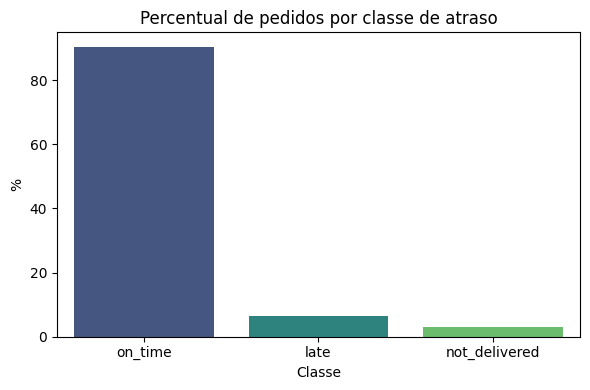

In [28]:
plt.figure(figsize=(6,4))
sns.barplot(data=res, x="delay_class", y="pct", palette="viridis")
plt.title("Percentual de pedidos por classe de atraso")
plt.ylabel("%")
plt.xlabel("Classe")
plt.tight_layout()
plt.show()


**Interpretação:** a maioria é entregue no prazo, mas há uma fração relevante de atrasos.


### 2.2 Tempo de entrega (delivery_days)
**Objetivo:** avaliar distribuição e dispersão do tempo de entrega.


In [29]:
sql = '''
SELECT delivery_days
FROM v_orders_clean
WHERE delivered_customer_ts IS NOT NULL;
'''
res = run_sql(sql)
res.describe()


,delivery_days
count,96476.000000
mean,12.497336
std,9.555460
min,0.000000
25%,7.000000
50%,10.000000
75%,16.000000
max,210.000000


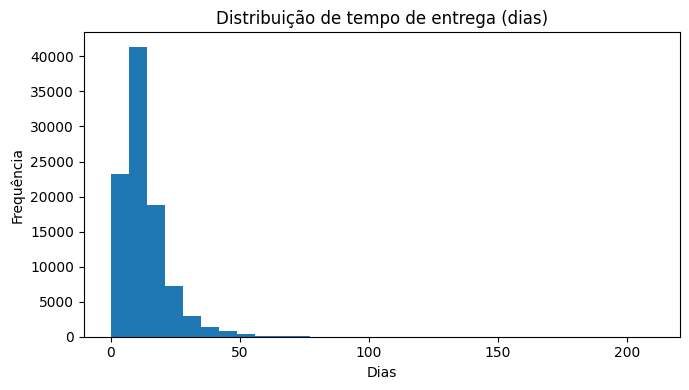

In [30]:
plt.figure(figsize=(7,4))
res["delivery_days"].plot(kind="hist", bins=30)
plt.title("Distribuição de tempo de entrega (dias)")
plt.xlabel("Dias")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()


**Interpretação:** alta dispersão; presença de outliers muito elevados.


### 2.3 Ticket médio e outliers
**Objetivo:** entender distribuição de valor total dos pedidos.


In [31]:
sql = '''
SELECT order_total_value
FROM v_order_value;
'''
res = run_sql(sql)
res.describe()


,order_total_value
count,98666.000000
mean,160.577638
std,220.466087
min,9.590000
25%,61.980000
50%,105.290000
75%,176.870000
max,13664.080000


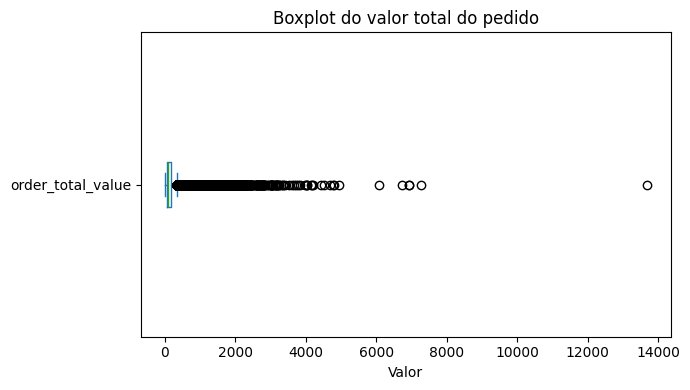

In [32]:
plt.figure(figsize=(7,4))
res["order_total_value"].plot(kind="box", vert=False)
plt.title("Boxplot do valor total do pedido")
plt.xlabel("Valor")
plt.tight_layout()
plt.show()


In [33]:
# Top 10 pedidos por valor
sql = '''
SELECT order_id, order_total_value, item_count
FROM v_order_value
ORDER BY order_total_value DESC
LIMIT 10;
'''
run_sql(sql)


,order_id,order_total_value,item_count
0,03caa2c082116e1d31e67e9ae3700499,13664.08,8
1,736e1922ae60d0d6a89247b851902527,7274.88,4
2,0812eb902a67711a1cb742b3cdaa65ae,6929.31,1
3,fefacc66af859508bf1a7934eab1e97f,6922.21,1
4,f5136e38d1a14a4dbd87dff67da82701,6726.66,1
5,2cc9089445046817a7539d90805e6e5a,6081.54,6
6,a96610ab360d42a2e5335a3998b4718a,4950.34,1
7,b4c4b76c642808cbe472a32b86cddc95,4809.44,2
8,199af31afc78c699f0dbf71fb178d4d4,4764.34,1
9,8dbc85d1447242f3b127dda390d56e19,4681.78,1


**Interpretação:** ticket médio moderado, mas existem pedidos muito acima da média.


### 2.4 Tendência temporal de pedidos e receita
**Objetivo:** analisar evolução mensal de pedidos e receita.


In [34]:
sql = '''
SELECT DATE_FORMAT(purchase_ts, '%Y-%m') ym,
       COUNT(*) orders,
       ROUND(SUM(order_total_value),2) revenue
FROM v_order_metrics
WHERE purchase_ts IS NOT NULL
GROUP BY ym
ORDER BY ym;
'''
res = run_sql(sql)
res.head()


,ym,orders,revenue
0,2016-09,4,354.75
1,2016-10,324,56808.84
2,2016-12,1,19.62
3,2017-01,800,137188.49
4,2017-02,1780,286280.62


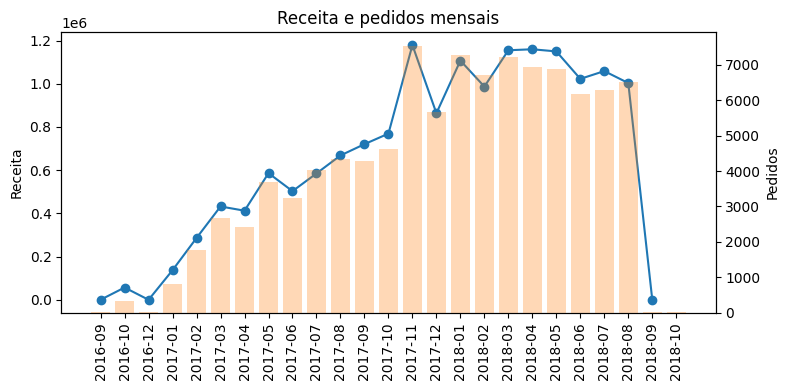

In [35]:
fig, ax1 = plt.subplots(figsize=(8,4))
ax1.plot(res["ym"], res["revenue"], color="tab:blue", marker="o")
ax1.set_ylabel("Receita")
ax1.tick_params(axis='x', rotation=90)

ax2 = ax1.twinx()
ax2.bar(res["ym"], res["orders"], color="tab:orange", alpha=0.3)
ax2.set_ylabel("Pedidos")

plt.title("Receita e pedidos mensais")
plt.tight_layout()
plt.show()


**Interpretação:** crescimento consistente até picos (ex.: Nov/2017), depois queda possivelmente por truncamento do dataset.


### 2.5 Distribuição regional (UF)
**Objetivo:** comparar volume e tempo médio de entrega por estado.


In [36]:
sql = '''
SELECT c.customer_state, COUNT(*) orders,
       ROUND(AVG(o.delivery_days),2) avg_delivery_days
FROM v_orders_clean o
JOIN olist_customers_dataset c ON o.customer_id = c.customer_id
WHERE o.delivery_days IS NOT NULL
GROUP BY c.customer_state
ORDER BY orders DESC;
'''
res = run_sql(sql)
res.head()


,customer_state,orders,avg_delivery_days
0,SP,40495,8.70
1,RJ,12353,15.24
2,MG,11355,11.95
3,RS,5344,15.25
4,PR,4923,11.94


<Figure size 800x400 with 0 Axes>

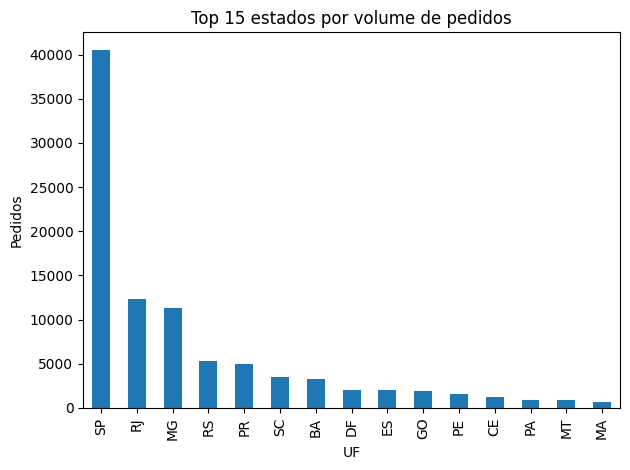

In [37]:
plt.figure(figsize=(8,4))
res.sort_values("orders", ascending=False).head(15).plot(
    x="customer_state", y="orders", kind="bar", legend=False
)
plt.title("Top 15 estados por volume de pedidos")
plt.ylabel("Pedidos")
plt.xlabel("UF")
plt.tight_layout()
plt.show()


**Interpretação:** SP domina em volume e possui menor tempo médio; regiões distantes tendem a maior lead time.


### 2.6 Categorias por receita
**Objetivo:** identificar categorias com maior receita.


In [38]:
sql = '''
SELECT COALESCE(NULLIF(p.product_category_name,''),'unknown') category,
       ROUND(SUM(oi.price + oi.freight_value),2) revenue,
       COUNT(*) items
FROM olist_order_items_dataset oi
JOIN olist_products_dataset p ON oi.product_id = p.product_id
GROUP BY category
ORDER BY revenue DESC
LIMIT 10;
'''
res = run_sql(sql)
res


,category,revenue,items
0,beleza_saude,1441248.07,9670
1,relogios_presentes,1305541.61,5991
2,cama_mesa_banho,1241681.72,11115
3,esporte_lazer,1156656.48,8641
4,informatica_acessorios,1059272.40,7827
5,moveis_decoracao,902511.79,8334
6,utilidades_domesticas,778397.77,6964
7,cool_stuff,719329.95,3796
8,automotivo,685384.32,4235
9,ferramentas_jardim,584219.21,4347


/var/folders/y_/6dwwysfx1qd4ycxj_kwh_vtr0000gn/T/ipykernel_61462/2124520343.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=res, x="revenue", y="category", palette="magma")


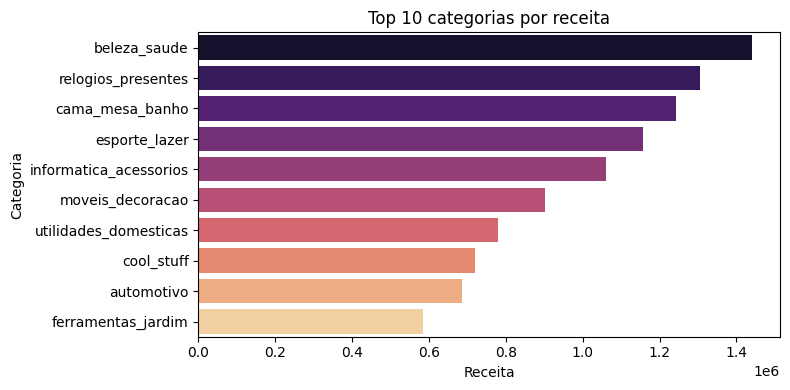

In [39]:
plt.figure(figsize=(8,4))
sns.barplot(data=res, x="revenue", y="category", palette="magma")
plt.title("Top 10 categorias por receita")
plt.xlabel("Receita")
plt.ylabel("Categoria")
plt.tight_layout()
plt.show()


**Interpretação:** categorias como beleza/saúde e presentes lideram receita.


### 2.7 Correlação item_count x valor do pedido (bônus)


In [40]:
sql = '''
SELECT (COUNT(*)*SUM(item_count*order_total_value) - SUM(item_count)*SUM(order_total_value))
       / SQRT((COUNT(*)*SUM(item_count*item_count) - POW(SUM(item_count),2)) *
              (COUNT(*)*SUM(order_total_value*order_total_value) - POW(SUM(order_total_value),2)))
       AS corr_itemcount_ordervalue
FROM v_order_value;
'''
run_sql(sql)


,corr_itemcount_ordervalue
0,0.189155


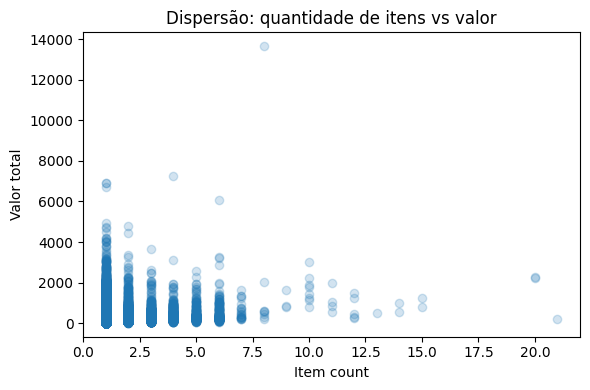

In [41]:
sql = '''
SELECT item_count, order_total_value
FROM v_order_value
WHERE order_total_value IS NOT NULL AND item_count IS NOT NULL;
'''
res = run_sql(sql)
plt.figure(figsize=(6,4))
plt.scatter(res["item_count"], res["order_total_value"], alpha=0.2)
plt.title("Dispersão: quantidade de itens vs valor")
plt.xlabel("Item count")
plt.ylabel("Valor total")
plt.tight_layout()
plt.show()


## 3) Visualizações (Resumo)
- Barras: atraso por classe
- Histograma: tempo de entrega
- Linha + barra: receita e pedidos mensais
- Barras horizontais: top categorias
- Dispersão: quantidade de itens x valor do pedido
- Boxplot: outliers de ticket médio
- Tabela analítica: top 10 pedidos


## 4) Looker Studio

### Estrutura do dashboard
1) **Topo**: KPIs globais
2) **Meio**: séries temporais (receita + pedidos)
3) **Meio**: mapa por UF
4) **Rodapé**: categorias + scatter + tabela analítica

### Dimensões e métricas
- **Dimensões**: `purchase_ts` (mês/ano), `customer_state`, `product_category_name`, `order_status`
- **Métricas**: `COUNT(order_id)`, `SUM(order_total_value)`, `AVG(delivery_days)`, `AVG(delay_days)`

## 5) Conclusão

Com base no dashboard entregue no Looker, os KPIs consolidados do projeto são: **receita total de 14.251.959,96**, **tempo médio de entrega de 12 dias**, **ticket médio de 98.666** e **99.441 pedidos** no período analisado. Esses indicadores mostram um volume robusto de pedidos e uma operação logística relativamente estável, ainda com margem para melhoria no tempo de entrega. A evolução mensal sugere variações ao longo do tempo, com retração no final da série, o que pode refletir sazonalidade ou limite de cobertura do dataset.

